# Hypothesis # 2
Refering to these age bins tailored to Financial and Investment Services:

Age Bins:
18-24 years: Entry-level savings, student loans.
25-34 years: First investments, retirement savings plans.
35-44 years: Wealth growth, family security.
45-54 years: Pre-retirement planning.
55-64 years: Diversifying portfolios, maximizing retirement funds.
65+ years: Retirement income and estate planning.

As our 2 most populated age groups are 25-34 (First investments, starting retirement saving plans) and 55-64 (diversifying portfolios, maximizing retirement funds), we are using a data driven approach to categorize these age groups as younger and older.

## We want to answer if the younger age group completes every stage faster than the older group in the control and test groups.

#### Null Hypothesis (H0): The average time spent per step for the younger age group (25-34) is equal to or greater than the average time spent per step for the older age group (55-64).
#### Alternative Hypothesis (H1): The average time spent per step for the younger age group (25-34) is less than the average time spent per step for the older age group (55-64).

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats

In [8]:
file_path = '../data/clean/df_cleaned.csv'
test2_df = pd.read_csv(file_path)

## Getting Data Ready for hypothesis testing
- Filtering data into age bins
- Creating a usable date/time column for calculation
- Creating a column to record time differences
- Grouping the data into younger (25-34) and older (55-64)
- Test display of the average seconds it takes for each step grouped by age group, control/test group and process step. 

In [16]:
# Define age bins and labels
bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Bin ages into groups
test2_df['age_group'] = pd.cut(test2_df['clnt_age'], bins=bins, labels=labels, right=False)

test2_df['date_time'] = pd.to_datetime(test2_df['date_time'], errors='coerce')

test2_df = test2_df.sort_values(by=['visit_id', 'date_time'])

# Calculate 'time_diff' after confirming proper datetime format
test2_df['time_diff'] = test2_df.groupby('visit_id')['date_time'].diff().dt.total_seconds()

# Filter for younger (25-34) and older (55-64) age groups
age_group_test = test2_df[test2_df['age_group'].isin(['25-34', '55-64'])].copy()

# Rename age groups for clarity
age_group_test['age_group'] = age_group_test['age_group'].replace({'25-34': 'younger', '55-64': 'older'})

# Retry grouping step
average_time_by_age_group = age_group_test.groupby(
    ['age_group', 'Variation', 'process_step'], observed=True)['time_diff'].mean().round().unstack(level=1)

# Reset index for hypothesis testing
average_time_by_age_group_df = average_time_by_age_group.reset_index()

average_time_by_age_group_df

/var/folders/hh/hx7f_d913pbf5gbc452qrps00000gp/T/ipykernel_19799/1944521684.py:19: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  age_group_test['age_group'] = age_group_test['age_group'].replace({'25-34': 'younger', '55-64': 'older'})


Variation,age_group,process_step,Control,Test
0,younger,confirm,96.0,91.0
1,younger,start,125.0,128.0
2,younger,step_1,32.0,31.0
3,younger,step_2,26.0,36.0
4,younger,step_3,89.0,92.0
5,older,confirm,153.0,163.0
6,older,start,170.0,156.0
7,older,step_1,50.0,42.0
8,older,step_2,46.0,54.0
9,older,step_3,94.0,97.0


## One-tailed Two-sample T-test
- WHAT: we performed t-tests to compare the mean time spent per step between the younger and older age groups. 
- WHY: The age groups are independent from each other and is categorical data, and the time spent per step is Continuous numerical data.
- HOW: One-tailed test performed for each control/test groups to see if younger users are faster. This approach tests whether the mean time for younger users is statistically significantly less than that of older users.

In [21]:
# Perform hypothesis testing 
results = []
for step in ['start', 'step_1', 'step_2', 'step_3', 'confirm']:
    for variation in ['Control', 'Test']:
        younger_times = age_group_test[(age_group_test['process_step'] == step) & (age_group_test['Variation'] == variation) & (age_group_test['age_group'] == 'younger')]['time_diff']
        older_times = age_group_test[(age_group_test['process_step'] == step) & (age_group_test['Variation'] == variation) & (age_group_test['age_group'] == 'older')]['time_diff']
        
        # Perform a one-tailed t-test
        t_stat, p_value = stats.ttest_ind(younger_times, older_times, alternative='less', nan_policy='omit')
        
        results.append({
            'process_step': step,
            'variation': variation,
            't_statistic': t_stat,
            'p_value': p_value
        })

# Convert results into a DataFrame
hypothesis_test_results_df = pd.DataFrame(results)

(hypothesis_test_results_df)

,process_step,variation,t_statistic,p_value
0,start,Control,-4.617126,1.979822e-06
1,start,Test,-4.314094,8.089974e-06
2,step_1,Control,-10.770910,3.109099e-27
3,step_1,Test,-7.593792,1.637901e-14
4,step_2,Control,-15.511063,5.327904e-54
5,step_2,Test,-10.625343,1.455127e-26
6,step_3,Control,-1.863660,3.119986e-02
7,step_3,Test,-2.097758,1.797489e-02
8,confirm,Control,-14.133938,4.634873e-45
9,confirm,Test,-13.346845,1.429189e-40


## Test Summary and Insights
- H0: mean time per step of younger >= mean time per step of older is REJECTED in all tests.
- The younger age group us significantly faster across age groups and test variations in all steps with all having a p-value below 0.05 (alpha).
- In step 3, the p-values are close to the thresold.

In [66]:
# Alpha level for statistical significance
alpha = 0.05

# Interpretation of results
interpretation = []
for _, row in hypothesis_test_results_df.iterrows():
    if row['p_value'] < alpha:
        interpretation.append(f"{row['process_step']} ({row['variation']}): Null hypothesis rejected (p = {row['p_value']:.2e}). Younger group is faster.")
    else:
        interpretation.append(f"{row['process_step']} ({row['variation']}): Null hypothesis not rejected (p = {row['p_value']:.2e}). No significant difference.")

# Display interpretations
for line in interpretation:
    print(line)

start (Control): Null hypothesis rejected (p = 1.98e-06). Younger group is faster.
start (Test): Null hypothesis rejected (p = 8.09e-06). Younger group is faster.
step_1 (Control): Null hypothesis rejected (p = 3.11e-27). Younger group is faster.
step_1 (Test): Null hypothesis rejected (p = 1.64e-14). Younger group is faster.
step_2 (Control): Null hypothesis rejected (p = 5.33e-54). Younger group is faster.
step_2 (Test): Null hypothesis rejected (p = 1.46e-26). Younger group is faster.
step_3 (Control): Null hypothesis rejected (p = 3.12e-02). Younger group is faster.
step_3 (Test): Null hypothesis rejected (p = 1.80e-02). Younger group is faster.
confirm (Control): Null hypothesis rejected (p = 4.63e-45). Younger group is faster.
confirm (Test): Null hypothesis rejected (p = 1.43e-40). Younger group is faster.


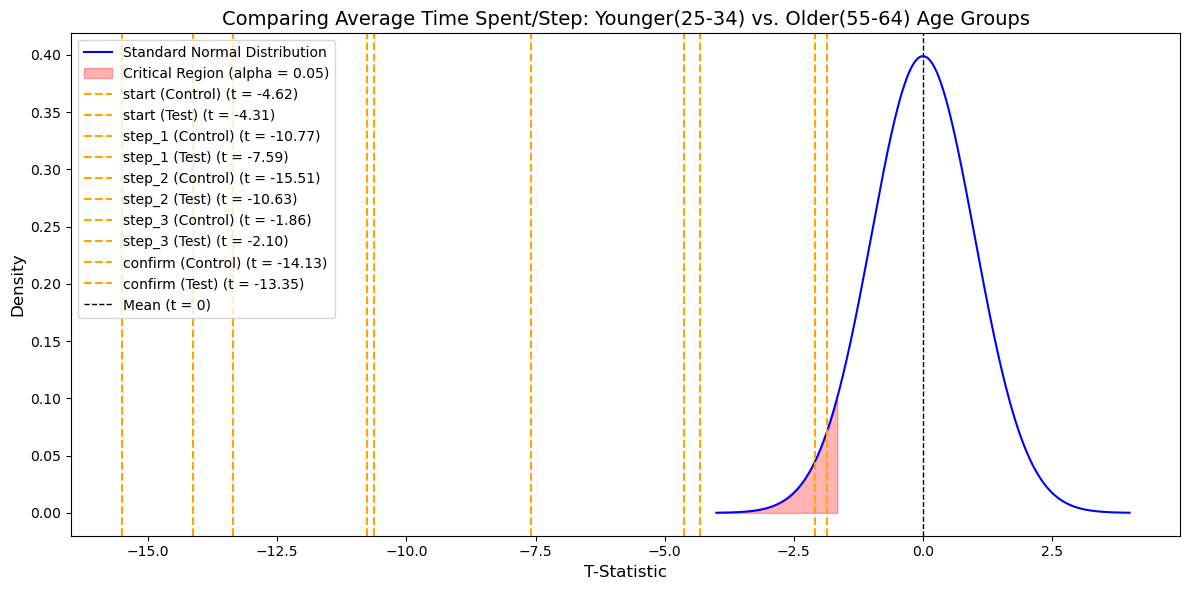

In [55]:
# Parameters for visualization
alpha = 0.05  # Significance level
critical_value = norm.ppf(alpha)  # Critical t-value for one-tailed test

# Example t-statistics from hypothesis test results
t_statistics = hypothesis_test_results_df['t_statistic'].values
labels = hypothesis_test_results_df[['process_step', 'variation']].apply(
    lambda x: f"{x['process_step']} ({x['variation']})", axis=1
)

# Generate data for the normal distribution curve
x = np.linspace(-4, 4, 500)
y = norm.pdf(x, 0, 1)

# Plot the normal distribution
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Standard Normal Distribution', color='blue')

# Highlight critical region
plt.fill_between(x, 0, y, where=(x <= critical_value), color='red', alpha=0.3, label=f"Critical Region (alpha = {alpha})")

# Add vertical lines for t-statistics
for t_stat, label in zip(t_statistics, labels):
    plt.axvline(t_stat, color='orange', linestyle='--', label=f"{label} (t = {t_stat:.2f})")

# Add legend, labels, and title
plt.title("Comparing Average Time Spent/Step: Younger(25-34) vs. Older(55-64) Age Groups", fontsize=14)
plt.xlabel("T-Statistic", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=1, label="Mean (t = 0)")
plt.legend(fontsize=10, loc='upper left')
plt.tight_layout()

plt.savefig("../figures/t-test.jpeg", format="jpeg", dpi=300)

# Show the plot
plt.show()
